<a href="https://colab.research.google.com/github/deboradcm/IARTES/blob/master/S%C3%A9ries_temporais_gerais_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook baseado nos tutoriais do Livro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff), capítulo 10.

# **Prognóstico de Séries Temporais**

Um exemplo de Prognóstico de Temperatura

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# 1. Dataset _weather_
Vamos usar a base de dados [weather](https://www.bgc-jena.mpg.de/wetter/) montado pelo [Instituto de Bioquímica Max-Planck](https://www.bgc-jena.mpg.de/index.php/Main/HomePage). É um conjunto de dados de série temporal meteorológica registrado na estação meteorológica no Instituto Max Planck de Biogeoquímica em Jena, Alemanha.

Esta base de dados contém 14 diferentes atributos tais como temperatura do ar, pressão atmosférica e umidade. Esses dados foram coletados a cada 10 minutos, começando em 2003. Vamos usar os dados entre 2009 e 2016, preparados por François Chollet -- [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-02-27 22:56:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.219.168, 52.216.138.189, 52.217.125.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.219.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  58.4MB/s    in 0.2s    

2024-02-27 22:56:38 (58.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### **Inspecionando a base de dados Jena weather**

In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
 base=pd.read_csv(fname)

In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [6]:
base.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


### **Analisando os Dados**

As observações são feitas a cada 10 minutos, ou seja, 6 por hora ou 144 por dia. Digamos que queremos observar 6 horas no futuro. Podemos usar uma _janela de tempo_ de 5 dias de observações (720 = 5 x 144) para treinar o modelo. Abaixo, nós convertemos todas as 420.451 linhas de dados em ***NumPy arrays ***: um array para a temperatura (em graus Celsius) e outro para o resto dos dados – as características que usaremos para prever temperaturas futuras. Observe que descartamos a coluna “Data e Hora”.

In [7]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [8]:
raw_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

### **Plotando as séries temporais de temperatura**

Na célula abaixo nós plotamos o gráfico da temperatura (em graus Celsius) ao longo do tempo. É possível ver claramente a periodicidade anual da temperatura – os dados abrangem 8 anos.

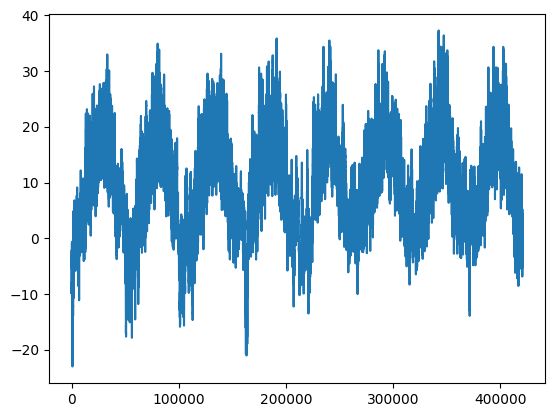

In [9]:
plt.plot(range(len(temperature)), temperature)

### **Plotando os primeiros 10 dias da série temporal de temperaturas**

Na próxima célula é plotado um gráfico que mostra os dados de temperatura dos  **10 primeiros dias**. Lembrando que os dados são registrados a cada **10 minutos**, portanto, são 24 × 6 = 144 pontos de dados por dia.

Text(0, 0.5, 'Temperatura')

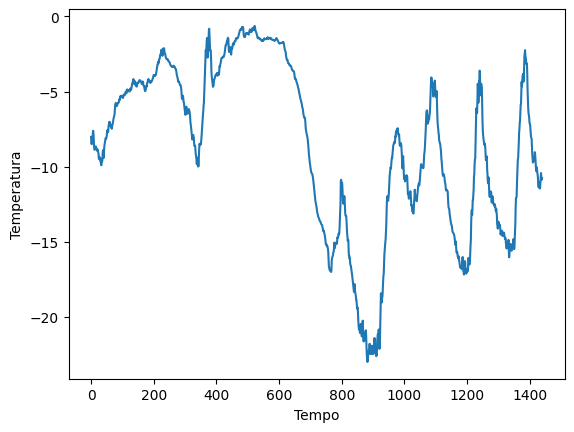

In [10]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Tempo')
plt.ylabel('Temperatura')

Neste gráfico é possível ver a periodicidade diária, principalmente dos últimos 4 dias. Observe também que este período de 10 dias deve vir de um mês de inverno bastante frio.

## Periodicidade dos DADOS

É sempre importante observarmos a periodicidade dos dados. A periodicidade em múltiplas escalas de tempo é uma propriedade importante e muito comum de
dados de série temporal. Quer você esteja observando o clima, a ocupação do estacionamento do shopping, o acesso a um site, vendas de um supermercado ou etapas registradas em um rastreador de fitness, quais ciclos devem ser considerados?

*   Ciclos diários;
*   Ciclos semanais;
*   Ciclos anuais;

Ao explorar os dados, é fundamental procurar esses padrões.

## **Separando a base de dados em treino, teste e validação**

Neste notebook nós usaremos os primeiros 20% dos dados para treinamento, os seguintes
10% para validação e os últimos 70% para teste.

Ao trabalhar com dados de séries temporais, é importante usar dados de validação e teste que sejam **mais recentes do que os dados de treinamento**, porque você está tentando **prever o futuro com base no passado**, e não o contrário,
e suas divisões de validação/teste devem refletir isso.

In [11]:
num_train_samples = int(0.2 * len(raw_data))
num_val_samples = int(0.1 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 84090
num_val_samples: 42045
num_test_samples: 294316


# 2. Preparação de Dados

## **Normalização dos Dados**

Primeiro, vamos pré-processar os dados em um formato que uma rede neural possa manusear. Como os dados já são numéricos, então não é necessário fazer nenhuma vetorização. Mas cada série temporal nos dados está em uma escala diferente (por exemplo, a pressão atmosférica medida em **mbar** é de cerca de 1.000, enquanto H2OC, medido em milimoles, é cerca de 3). Normalizaremos cada série temporal de forma independente para que todas elas
assumam pequenos valores em uma escala semelhante.

Nós calcularemos a média e o desvio padrão apenas para os dados de treinamento.

In [12]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## **Instanciando as bases de treino, validação, e teste**

A formulação exata do problema será a seguinte: considerando os dados de cinco dias anteriores, amostrados uma vez por hora, podemos prever a temperatura em 24 horas?
A seguir, vamos criar um objeto Dataset que produza lotes de dados dos últimos cinco dias juntamente com uma temperatura alvo de 24 horas no futuro.

Nós usaremos o utilitário do Keras (`timeseries_dataset_from_array()`), para fornecer janelas de dados extraídas da série temporal original (chamadas de “sequências”).
Esse utilitário gera também os alvos. A primeira entrada da matriz de alvos deve corresponder ao alvo desejado
para a primeira sequência que será gerada a partir da matriz de dados.

Nós usaremos os seguintes valores de parâmetro:

*   sampling_rate = 6 — As observações serão amostradas em um ponto de dados: apenas um ponto de dados em 6.
*   sequence_length = 120 — As observações retrocederão 5 dias (120 horas).
*   delay = sampling_rate * (sequence_length + 24 - 1) — O alvo para uma sequência será a temperatura 24 horas após o término da sequência.

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 #mini set

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

## **Inspecionando a saída de um dos conjuntos de dados**

Cada conjunto de dados produz uma tupla (amostras, alvos), onde amostras é um lote de 256 amostras,
cada uma contendo 120 horas consecutivas de dados de entrada, e os alvos são as correspondentes 256 temperaturas alvo. Observe que as amostras são embaralhadas aleatoriamente, portanto, duas sequências consecutivas em um lote (como samples[0] e samples[1]) não estão necessariamente temporalmente próximas.

In [14]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


# 3 - Métodos de Previsão

### **3.1 Um *baseline* de senso comum não baseado em aprendizagem de máquina**

Antes de começarmos a usar modelos de aprendizagem caixa preta para resolver o problema de previsão de temperatura, vamos tentar uma abordagem simples e de senso comum. Essa abordagem servirá como um teste de sanidade e estabelecerá um baseline que teremos que superar para demonstrar a utilidade de modelos de aprendizado de máquina mais avançados.

## **Computando o baseline MAE**

No nosso caso, uma abordagem de senso comum seria sempre prever que a temperatura daqui a 24 horas será igual à temperatura
atual. Vamos avaliar essa abordagem, usando a métrica do erro absoluto médio
 (MAE).

In [15]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.63
Test MAE: 2.59


O *baseline* produziu um MAE de validação de 2,63 graus Celsius e um
 MAE de teste de 2,59 graus Celsius. Então, se o modelo sempre assumir que a temperatura 24 horas no futuro será a mesma que é agora, o modelo estará errado por dois graus e meio em média. Não é tão ruim, mas provavelmente um serviço de previsão do tempo baseado nesta heurística não será lançado.

### **3.2 Vamos tentar um modelo de aprendizagem de máquina básico**

Também é útil tentar modelos de aprendizado de máquina rasos/simples, antes de tentar soluções mais complicadas e caras computacionalmente. Esta é a melhor maneira de garantir que qualquer complexidade adicionada é legítima e traz benefícios reais.
Abaixo nós usamos um modelo totalmente conectado que começa achatando os
dados e, em seguida, executa-os através de duas camadas densas. Observe a falta de uma função de ativação na última camada Densa, o que é típico de um problema de regressão. Usamos a média erro quadrado (MSE) como perda, em vez de MAE, porque, ao contrário do MAE, é suave em torno de zero, o que é uma propriedade útil para descida gradiente. Iremos monitorar o MAE ao adicionálo como uma métrica em `compile()`.

### **Treinando e avaliando uma MLP**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
326/326 [==============================] - 17s 49ms/step - loss: 18.0541 - mae: 3.2289 - val_loss: 13.4244 - val_mae: 2.9423
Epoch 2/10
326/326 [==============================] - 16s 48ms/step - loss: 9.0974 - mae: 2.3517 - val_loss: 12.8377 - val_mae: 2.8245
Epoch 3/10
326/326 [==============================] - 17s 51ms/step - loss: 8.0775 - mae: 2.2155 - val_loss: 13.1935 - val_mae: 2.8515
Epoch 4/10
326/326 [==============================] - 16s 49ms/step - loss: 7.3289 - mae: 2.1061 - val_loss: 13.2383 - val_mae: 2.8572
Epoch 5/10
326/326 [==============================] - 16s 48ms/step - loss: 6.7838 - mae: 2.0298 - val_loss: 13.7171 - val_mae: 2.9090
Epoch 6/10
326/326 [==============================] - 16s 49ms/step - loss: 6.4603 - mae: 1.9794 - val_loss: 14.5544 - val_mae: 2.9718
Epoch 7/10
326/326 [==============================] - 17s 51ms/step - loss: 6.1752 - mae: 1.9314 - val_loss: 13.8019 - val_mae: 2.9168
Epoch 8/10
326/326 [==============================] - 

**Exibição Gráfica dos Resultados**

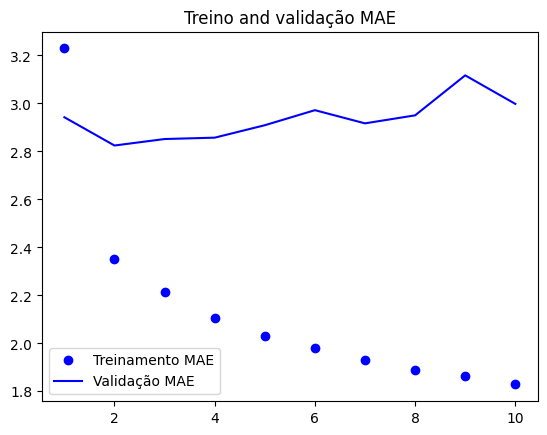

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Treinamento MAE")
plt.plot(epochs, val_loss, "b", label="Validação MAE")
plt.title("Treino and validação MAE")
plt.legend()
plt.show()

Alguns valores de perda na validação estão próximos dos valores do baseline sem aprendizagem. Isso demonstra o mérito de ter o baseline: não é fácil superá-lo. O baseline tem conhecimento a priori do problema ao qual o modelo de aprendizado de máquina não tem acesso.

Essa é uma limitação bastante significativa do aprendizado de máquina em geral:
às vezes o modelo não consegue encontrar uma solução simples para um problema simples.


## **3.3 Vamos tentar um modelo de CNN 1D**:
Considerando que nossas sequências de entrada apresentam ciclos diários, talvez um modelo convolucional pudesse funcionar. Uma rede temporal
poderia reutilizar as mesmas representações em dias diferentes, como uma rede espacial pode reutilizar as mesmas representações em diferentes locais de uma imagem.

As camadas Conv1D empregam janelas 1D que deslizam sobre as sequências de entrada. São operações adequadas para dados de sequência que sigam a suposição de invariância de translação (ou seja, se você deslizar uma janela sobre a sequência, o conteúdo da janela deverá seguir as mesmas propriedades independentemente da localização da janela).
Em nosso problema de previsão de temperatura, nós escolheremos uma janela inicial de comprimento igual a 24, para que possamos analisar 24 horas de dados por vez (um ciclo). À medida que reduzimos a resolução nas sequências (por meio das camadas MaxPooling1D), reduziremos o tamanho da janela de acordo:

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
326/326 [==============================] - 34s 102ms/step - loss: 23.8234 - mae: 3.7996 - val_loss: 21.0231 - val_mae: 3.6833
Epoch 2/10
326/326 [==============================] - 29s 88ms/step - loss: 15.6886 - mae: 3.1334 - val_loss: 19.0695 - val_mae: 3.5193
Epoch 3/10
326/326 [==============================] - 28s 86ms/step - loss: 13.8497 - mae: 2.9303 - val_loss: 19.9780 - val_mae: 3.6360
Epoch 4/10
326/326 [==============================] - 29s 87ms/step - loss: 12.8908 - mae: 2.8145 - val_loss: 19.2948 - val_mae: 3.5309
Epoch 5/10
326/326 [==============================] - 28s 85ms/step - loss: 12.0266 - mae: 2.7175 - val_loss: 19.5684 - val_mae: 3.5692
Epoch 6/10
326/326 [==============================] - 33s 101ms/step - loss: 11.3694 - mae: 2.6463 - val_loss: 19.5554 - val_mae: 3.5389
Epoch 7/10
326/326 [==============================] - 29s 88ms/step - loss: 10.8612 - mae: 2.5820 - val_loss: 20.7700 - val_mae: 3.6458
Epoch 8/10
326/326 [==========================

**Exibição Gráfica dos Resultados**

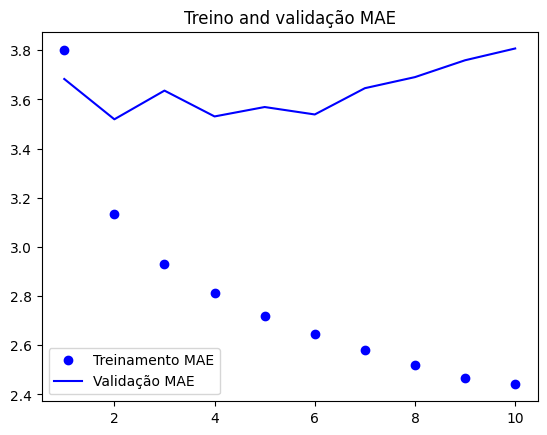

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Treinamento MAE")
plt.plot(epochs, val_loss, "b", label="Validação MAE")
plt.title("Treino and validação MAE")
plt.legend()
plt.show()

O modelo CNN1D tem desempenho ainda pior do que o modelo densamente conectado, bem abaixo do baseline. O que justifica esse resultado?
* **Dados meteorológicos não respeitam** totalmente a suposição de invariância de translação. Embora os dados apresentem ciclos diários, os dados de uma manhã seguem diferentes propriedades do que dados de uma noite ou do meio da noite. Dados de clima são invariantes à translação apenas por uma escala de tempo muito específica.
* **A ordem dos dados é muito importante**. O passado recente é muito mais informativo para prever a temperatura do dia seguinte do que os dados de cinco dias atrás. A CNN1D não é capaz de aproveitar esse fato. Em particular, as operações de *max pooling* e *global average pooling* estão destruindo em grande parte as informações de ordem entre os dados.

### **3.4 Usando Redes Neurais Recorrentes**

Nem a abordagem totalmente conectada nem a abordagem convolucional tiveram bom desempenho:

*   O modelo densamente conectado primeiro achatou a série temporal, o que removeu a noção de tempo dos dados de entrada.
*   A abordagem convolucional tratou cada segmento dos dados da mesma forma, inclusive aplicando pooling, fato que pode ter perdido informações de ordem.

Agora nós vamos tentar uma técnica que olhe para os dados como eles são: uma sequência, onde a causalidade e a ordem são importantes. Trata-se de uma família de arquiteturas de redes neurais projetadas especificamente para esse caso de uso: **redes neurais recorrentes**. Dentre elas, as LSTM.

**Um modelo baseado em LSTM simples**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

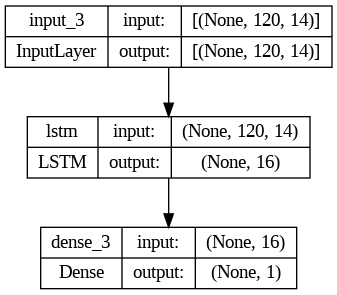

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
326/326 [==============================] - 39s 112ms/step - loss: 78.1542 - mae: 6.8294 - val_loss: 27.6587 - val_mae: 4.1053
Epoch 2/10
326/326 [==============================] - 37s 111ms/step - loss: 29.4202 - mae: 3.9540 - val_loss: 15.9280 - val_mae: 3.0830
Epoch 3/10
326/326 [==============================] - 37s 112ms/step - loss: 14.1836 - mae: 2.8151 - val_loss: 13.6672 - val_mae: 2.8971
Epoch 4/10
326/326 [==============================] - 34s 102ms/step - loss: 10.0073 - mae: 2.4311 - val_loss: 15.7273 - val_mae: 3.0544
Epoch 5/10
326/326 [==============================] - 33s 101ms/step - loss: 8.9700 - mae: 2.3133 - val_loss: 14.2157 - val_mae: 2.9813
Epoch 6/10
326/326 [==============================] - 37s 112ms/step - loss: 8.5948 - mae: 2.2634 - val_loss: 14.2380 - val_mae: 2.9705
Epoch 7/10
326/326 [==============================] - 35s 105ms/step - loss: 8.3371 - mae: 2.2261 - val_loss: 15.7902 - val_mae: 3.1052
Epoch 8/10
326/326 [========================

**Exibição Gráfica dos Resultados**

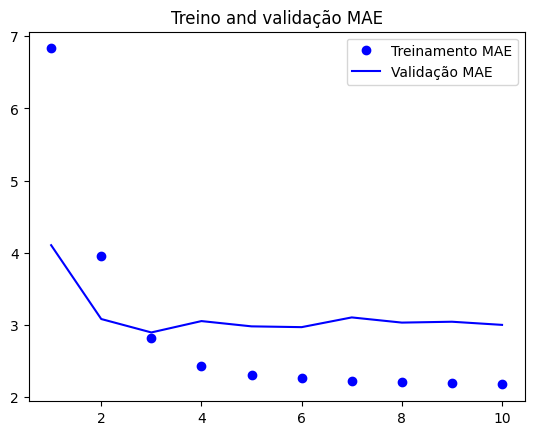

In [23]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Treinamento MAE")
plt.plot(epochs, val_loss, "b", label="Validação MAE")
plt.title("Treino and validação MAE")
plt.legend()
plt.show()

O resultado foi bem melhor. Foi obtido um MAE de validação em torno de 2,80
graus e um MAE de teste de 2.66 graus. O modelo baseado em LSTM não ultrapassou o baseline, mas ficou bem próximo.

Uma característica importante das redes neurais anteriores é que elas não têm memória, diferentemente do que ocorre com as RNN.

**LSTM com Dropout**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=16,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/16
326/326 [==============================] - 86s 256ms/step - loss: 45.7180 - mae: 5.0081 - val_loss: 15.1582 - val_mae: 3.0126
Epoch 2/16
326/326 [==============================] - 66s 203ms/step - loss: 17.2836 - mae: 3.1726 - val_loss: 12.1136 - val_mae: 2.6929
Epoch 3/16
326/326 [==============================] - 67s 205ms/step - loss: 14.6838 - mae: 2.9455 - val_loss: 12.1732 - val_mae: 2.7000
Epoch 4/16
326/326 [==============================] - 67s 204ms/step - loss: 14.0157 - mae: 2.8820 - val_loss: 12.5844 - val_mae: 2.7599
Epoch 5/16
326/326 [==============================] - 77s 235ms/step - loss: 13.5257 - mae: 2.8221 - val_loss: 13.0597 - val_mae: 2.7978
Epoch 6/16
326/326 [==============================] - 67s 204ms/step - loss: 13.1457 - mae: 2.7834 - val_loss: 13.2245 - val_mae: 2.8369
Epoch 7/16
326/326 [==============================] - 69s 211ms/step - loss: 12.8101 - mae: 2.7443 - val_loss: 13.3368 - val_mae: 2.8737
Epoch 8/16
326/326 [=====================

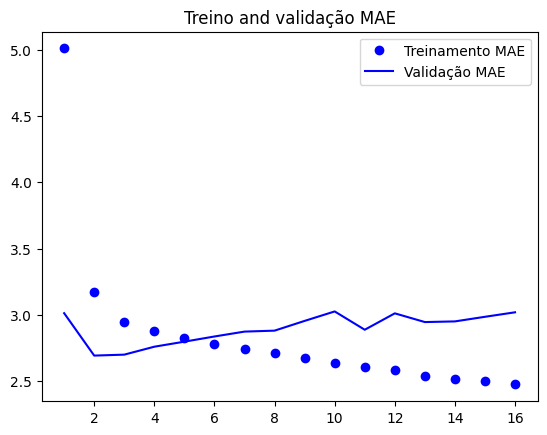

In [25]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Treinamento MAE")
plt.plot(epochs, val_loss, "b", label="Validação MAE")
plt.title("Treino and validação MAE")
plt.legend()
plt.show()